# Cloning the repo

Installing keras-retinanet repo

In [0]:
!pip install keras==2.3.1

     |████████████████████████████████| 378kB 2.9MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
%cd /content
!rm -rf keras-*
!git clone https://github.com/fizyr/keras-retinanet.git
%cd keras-retinanet 
!python setup.py build_ext --inplace --user
!pip install .
%cd /content

/content
Cloning into 'keras-retinanet'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 5161 (delta 9), reused 9 (delta 3), pack-reused 5127
Receiving objects: 100% (5161/5161), 13.94 MiB | 30.11 MiB/s, done.
Resolving deltas: 100% (3432/3432), done.
/content/keras-retinanet
running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-

Downloading soccer data from Haizaha

In [0]:
!mkdir data 
!wget https://playground.haizaha.com/soccer-player-and-ball-localization/retinanet_csv.zip -O data/retinanet_csv.zip 
%cd data
!unzip retinanet_csv.zip  
%cd ..

mkdir: cannot create directory ‘data’: File exists
--2019-10-18 07:32:34--  https://playground.haizaha.com/soccer-player-and-ball-localization/retinanet_csv.zip
Resolving playground.haizaha.com (playground.haizaha.com)... 51.75.14.194
Connecting to playground.haizaha.com (playground.haizaha.com)|51.75.14.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 337356510 (322M) [application/zip]
Saving to: ‘data/retinanet_csv.zip’

data/retinanet_csv. 100%[===================>] 321.73M  30.9MB/s    in 11s     

2019-10-18 07:32:45 (29.2 MB/s) - ‘data/retinanet_csv.zip’ saved [337356510/337356510]

/content/data
Archive:  retinanet_csv.zip
  inflating: data.csv                
   creating: images/
  inflating: images/frame_0001.jpg   
  inflating: images/frame_0002.jpg   
  inflating: images/frame_0003.jpg   
  inflating: images/frame_0004.jpg   
  inflating: images/frame_0005.jpg   
  inflating: images/frame_0006.jpg   
  inflating: images/frame_0007.jpg   
  inflat

# Download pre-trained weights

In [0]:
!mkdir pre-trained 
!wget https://playground.haizaha.com/soccer-player-and-ball-localization/resnet50_csv_last.h5 -O pre-trained/resnet50_csv_last.h5

--2019-10-18 07:17:06--  https://playground.haizaha.com/soccer-player-and-ball-localization/resnet50_csv_last.h5
Resolving playground.haizaha.com (playground.haizaha.com)... 51.75.14.194
Connecting to playground.haizaha.com (playground.haizaha.com)|51.75.14.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 437173264 (417M) [application/octet-stream]
Saving to: ‘pre-trained/resnet50_csv_last.h5’

pre-trained/resnet5 100%[===================>] 416.92M  30.9MB/s    in 14s     

2019-10-18 07:17:20 (29.6 MB/s) - ‘pre-trained/resnet50_csv_last.h5’ saved [437173264/437173264]



Compile training model to inference model

In [0]:
!python /content/keras-retinanet/keras_retinanet/bin/convert_model.py pre-trained/resnet50_csv_last.h5  pre-trained/resnet50_csv_last_inference.h5 

Using TensorFlow backend.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

2019-10-18 07:19:52.206109: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-10-18 07:19:52.208995: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2019-10-18 07:19:52.209103: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 5d06c8bdb506
2019-10-18 07:19:52.209122: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 5d06c8bdb506
2019-10-18 07:19:52.209215: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 418.67.0
2019-10-18 07:19:52.209274: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 418.67.0
2019-10-18 07:19:52.209289: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc

# Loading necessary modules

In [0]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


# Utils

Displaying training data

In [0]:
def view_detections(image_path, csv_file):
    filename = os.path.basename(image_path)
    image = read_image_bgr(image_path)
    
    annotations = [a for a in [i.split(",") for i in open(csv_file).read().split("\n")] if filename in a[0]]
    
    boxes = np.vstack([i[1:-1] for i in annotations]).astype("i")
    
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    for box in boxes: 

        color = label_color(1)

        b = box.astype(int)
        draw_box(draw, b, color=color)
        
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()
   

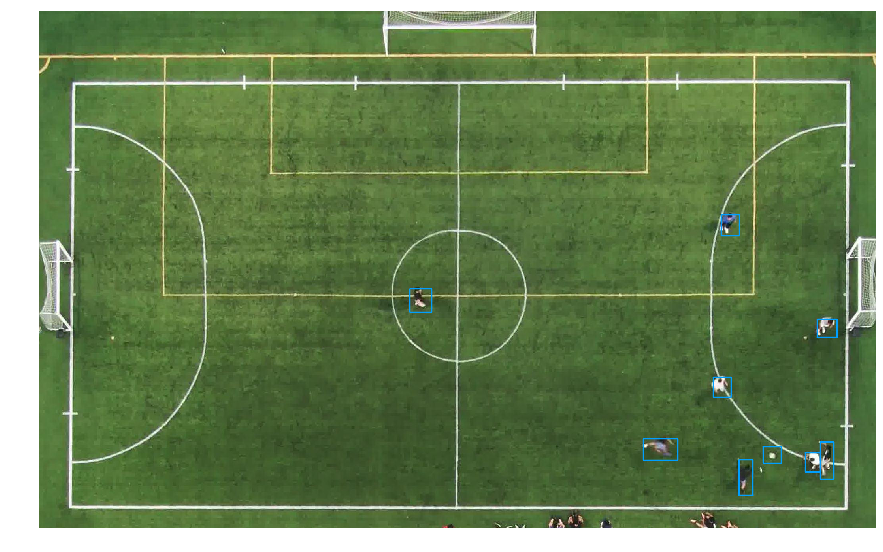

In [0]:
view_detections("data/images/frame_0033.jpg", "data/data.csv")

Run detection utils

In [0]:
def run_detection(model, filepath, labels_file="data/labels.csv"):
  
    labels = [i.split(",") for i in open(labels_file).read().split("\n")]
    labels_to_names = dict([(int(str_id), name) for name, str_id in labels])
    
    image = read_image_bgr(filepath) 

    #plt.figure(figsize=(15, 15))
    #plt.axis('off')
    #plt.imshow(image)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        print(box, score, label)
        if (label == 0 and score < .3) or score < .5: 
            break
        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, b, caption)

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show() 

Model loading helper

In [0]:
def load_model(model_path): 
   return models.load_model(model_path, backbone_name='resnet50')

# Inference

Running detections

In [0]:
# loading the model
model = load_model('pre-trained/resnet50_csv_last_inference.h5')

In [0]:
# running the model
run_detection(model, "data/images/frame_0150.jpg", "data/labels.csv") 
 

# Re-training the model

Testing GPU

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Training the model

In [0]:
!python keras-retinanet/keras_retinanet/bin/train.py --steps 10 --epochs 1 --gpu 0 --snapshot pre-trained/resnet50_csv_last.h5   csv data/train.csv data/labels.csv --val-annotations data/valid.csv

Converting to inference model

In [0]:
!python /content/keras-retinanet/keras_retinanet/bin/convert_model.py ./snapshots/resnet50_csv_01.h5  ./snapshots/resnet50_csv_01_inference.h5

Inference with new weights

In [0]:
model = load_model('./snapshots/resnet50_csv_01_inference.h5')
run_detection(model, "data/images/frame_0001.jpg", "data/labels.csv") 